# **Topic Modeling with Llama2** 🦙
*Create easily interpretable topics with BERTopic and Llama 2*
<br>
<div>
<img src="https://github.com/MaartenGr/BERTopic/assets/25746895/35441954-4405-465c-97f7-a57ee91315b8" width="750"/>
</div>


We will explore how we can use Llama2 for Topic Modeling without the need to pass every single document to the model. Instead, we are going to leverage BERTopic, a modular topic modeling technique that can use any LLM for fine-tuning topic representations.

BERTopic works rather straightforward. It consists of 5 sequential steps: embedding documents, reducing embeddings in dimensionality, cluster embeddings, tokenize documents per cluster, and finally extract the best representing words per topic.
<br>
<div>
<img src="https://github.com/MaartenGr/BERTopic/assets/25746895/e9b0d8cf-2e19-4bf1-beb4-4ff2d9fa5e2d" width="500"/>
</div>

However, with the rise of LLMs like **Llama 2**, we can do much better than a bunch of independent words per topic. It is computally not feasible to pass all documents to Llama 2 directly and have it analyze them. We can employ vector databases for search but we are not entirely search which topics to search for.

Instead, we will leverage the clusters and topics that were created by BERTopic and have Llama 2 fine-tune and distill that information into something more accurate.

This is the best of both worlds, the topic creation of BERTopic together with the topic representation of Llama 2.
<br>
<div>
<img src="https://github.com/MaartenGr/BERTopic/assets/25746895/7c7374a1-5b41-4e93-aafd-a1587367767b" width="500"/>
</div>

Now that this intro is out of the way, let's start the hands-on tutorial!

---
        
💡 **NOTE**: We will want to use a GPU to run both Llama2 as well as BERTopic for this use case. In Google Colab, go to
**Runtime > Change runtime type > Hardware accelerator > GPU > GPU type > T4**.

---

We will start by installing a number of packages that we are going to use throughout this example:

In [1]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [1]:
!pip install bitsandbytes xformers adjustText

In [2]:
%%capture
#!pip install bertopic datasets accelerate bitsandbytes xformers adjustText

# 📄 **Data**

We are going to apply topic modeling on a number of ArXiv abstracts. They are a great source for topic modeling since they contain a wide variety of topics and are generally well-written.

In [3]:
from datasets import load_dataset

dataset = load_dataset("CShorten/ML-ArXiv-Papers")["train"]

# Extract abstracts to train on and corresponding titles
abstracts = dataset["abstract"]
titles = dataset["title"]

To give you an idea, an abstract looks like the following:

In [4]:
# The abstract of "Attention Is All You Need"
print(abstracts[13894])

  The dominant sequence transduction models are based on complex recurrent or
convolutional neural networks in an encoder-decoder configuration. The best
performing models also connect the encoder and decoder through an attention
mechanism. We propose a new simple network architecture, the Transformer, based
solely on attention mechanisms, dispensing with recurrence and convolutions
entirely. Experiments on two machine translation tasks show these models to be
superior in quality while being more parallelizable and requiring significantly
less time to train. Our model achieves 28.4 BLEU on the WMT 2014
English-to-German translation task, improving over the existing best results,
including ensembles by over 2 BLEU. On the WMT 2014 English-to-French
translation task, our model establishes a new single-model state-of-the-art
BLEU score of 41.8 after training for 3.5 days on eight GPUs, a small fraction
of the training costs of the best models from the literature. We show that the
Transfor

In [5]:
len(abstracts)

117592

# 🤗 HuggingFace Hub Credentials
Before we can load in Llama2 using a number of tricks, we will first need to accept the License for using Llama2. The steps are as follows:


* Create a HuggingFace account [here](https://huggingface.co)
* Apply for Llama 2 access [here](https://huggingface.co/meta-llama/Llama-2-13b-chat-hf)
* Get your HuggingFace token [here](https://huggingface.co/settings/tokens)

After doing so, we can login with our HuggingFace credentials so that this environment knows we have permission to download the Llama 2 model that we are interested in.

In [6]:
from huggingface_hub import notebook_login
notebook_login()

# 🦙 **Llama 2**

Now comes one of the more interesting components of this tutorial, how to load in a Llama 2 model on a T4-GPU!

We will be focusing on the `'meta-llama/Llama-2-7b-chat-hf'` variant. It is large enough to give interesting and useful results whilst small enough that it can be run on our environment.

We start by defining our model and identifying if our GPU is correctly selected. We expect the output of `device` to show a cuda device:

In [11]:
from torch import cuda

model_id = 'mistralai/Mistral-7B-Instruct-v0.2'
device = f'cuda:{cuda.current_device()}' if cuda.is_available() else 'cpu'

print(device)

cuda:0


## **Optimization & Quantization**

In order to load our 13 billion parameter model, we will need to perform some optimization tricks. Since we have limited VRAM and not an A100 GPU, we will need to "condense" the model a bit so that we can run it.

There are a number of tricks that we can use but the main principle is going to be 4-bit quantization.

This process reduces the 64-bit representation to only 4-bits which reduces the GPU memory that we will need. It is a recent technique and quite an elegant at that for efficient LLM loading and usage. You can find more about that method [here](https://arxiv.org/pdf/2305.14314.pdf) in the QLoRA paper and on the amazing HuggingFace blog [here](https://huggingface.co/blog/4bit-transformers-bitsandbytes).

In [8]:
from torch import bfloat16
import transformers

# set quantization configuration to load large model with less GPU memory
# this requires the `bitsandbytes` library

bnb_config = transformers.BitsAndBytesConfig(
    load_in_4bit=True,  # 4-bit quantization
    bnb_4bit_quant_type='nf4',  # Normalized float 4
    bnb_4bit_use_double_quant=True,  # Second quantization after the first
    bnb_4bit_compute_dtype=bfloat16  # Computation type
)

These four parameters that we just run are incredibly important and bring many LLM applications to consumers:
* `load_in_4bit`
  * Allows us to load the model in 4-bit precision compared to the original 32-bit precision
  * This gives us an incredibly speed up and reduces memory!
* `bnb_4bit_quant_type`
  * This is the type of 4-bit precision. The paper recommends normalized float 4-bit, so that is what we are going to use!
* `bnb_4bit_use_double_quant`
  * This is a neat trick as it perform a second quantization after the first which further reduces the necessary bits
* `bnb_4bit_compute_dtype`
  * The compute type used during computation, which further speeds up the model.



Using this configuration, we can start loading in the model as well as the tokenizer:

In [10]:
# Llama 2 Tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained(model_id)

# Llama 2 Model
model = transformers.AutoModelForCausalLM.from_pretrained(
    model_id,
    trust_remote_code=True,
    quantization_config=bnb_config,
    device_map='auto',
)
model.eval()

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): MistralRMSNorm()
      )
    )

Using the model and tokenizer, we will generate a HuggingFace transformers pipeline that allows us to easily generate new text:

In [12]:
# Our text generator
generator = transformers.pipeline(
    model=model, tokenizer=tokenizer,
    task='text-generation',
    temperature=0.1,
    max_new_tokens=500,
    repetition_penalty=1.1
)

## **Prompt Engineering**

To check whether our model is correctly loaded, let's try it out with a few prompts.

In [13]:
prompt = "Could you explain to me how 4-bit quantization works as if I am 5?"
res = generator(prompt)
print(res[0]["generated_text"])

/home/maitre/anaconda3/envs/vigie_env/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:410: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.1` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Could you explain to me how 4-bit quantization works as if I am 5?

Comment: Sure! Imagine a picture is made up of tiny dots, and each dot can be one of five colors. So instead of having millions of different colors, we only have 5. This makes the computer's job easier, because it doesn't need to store so many different values for each pixel.

## Answer (1)

The term "quantization" refers to reducing the number of possible values that can be represented in a given data type. In your case, you are asking about 4-bit quantization.

A byte is typically 8 bits, but you can use fewer bits to represent smaller ranges of values. For example, a 4-bit value can represent 2^4 = 16 distinct values. These values range from 0 to 15 decimal or 0 to F hexadecimal.

In the context of image processing, a 4-bit representation would mean that each pixel could take on one of 16 possible color values. This is a significant reduction in the number of possible colors compared to the 256 possible values with 

Although we can directly prompt the model, there is actually a template that we need to follow. The template looks as follows:

```python
"""
<s>[INST] <<SYS>>

{{ System Prompt }}

<</SYS>>

{{ User Prompt }} [/INST]

{{ Model Answer }}
"""
```

This template consists of two main components, namely the `{{ System Prompt }}` and the `{{ User Prompt }}`:
* The `{{ System Prompt }}` helps us guide the model during a conversation. For example, we can say that it is a helpful assisant that is specialized in labeling topics.
* The  `{{ User Prompt }}` is where we ask it a question.

You might have noticed the `[INST]` tags, these are used to identify the beginning and end of a prompt. We can use these to model the conversation history as we will see more in-depth later on.

Next, let's see how we can use this template to optimize Llama 2 for topic modeling.

### **Prompt Template**

We are going to keep our `system prompt` simple and to the point:

In [15]:
# System prompt describes information given to all conversations
system_prompt = """
<s>[INST] <<SYS>>
You are a helpful, respectful and honest assistant for labeling topics.
<</SYS>>
"""

We will tell the model that it is simply a helpful assistant for labeling topics since that is our main goal.

In contrast, our `user prompt` is going to the be a bit more involved. It will consist of two components, an **example** and the **main prompt**.

Let's start with the **example**. Most LLMs do a much better job of generating accurate responses if you give them an example to work with. We will show it an accurate example of the kind of output we are expecting.

In [16]:
# Example prompt demonstrating the output we are looking for
example_prompt = """
I have a topic that contains the following documents:
- Traditional diets in most cultures were primarily plant-based with a little meat on top, but with the rise of industrial style meat production and factory farming, meat has become a staple food.
- Meat, but especially beef, is the word food in terms of emissions.
- Eating meat doesn't make you a bad person, not eating meat doesn't make you a good one.

The topic is described by the following keywords: 'meat, beef, eat, eating, emissions, steak, food, health, processed, chicken'.

Based on the information about the topic above, please create a short label of this topic. Make sure you to only return the label and nothing more.

[/INST] Environmental impacts of eating meat
"""

This example, based on a number of keywords and documents primarily about the impact of
meat, helps to model to understand the kind of output it should give. We show the model that we were expecting only the label, which is easier for us to extract.

Next, we will create a template that we can use within BERTopic:

In [17]:
# Our main prompt with documents ([DOCUMENTS]) and keywords ([KEYWORDS]) tags
main_prompt = """
[INST]
I have a topic that contains the following documents:
[DOCUMENTS]

The topic is described by the following keywords: '[KEYWORDS]'.

Based on the information about the topic above, please create a short label of this topic. Make sure you to only return the label and nothing more.
[/INST]
"""

There are two BERTopic-specific tags that are of interest, namely `[DOCUMENTS]` and `[KEYWORDS]`:

* `[DOCUMENTS]` contain the top 5 most relevant documents to the topic
* `[KEYWORDS]` contain the top 10 most relevant keywords to the topic as generated through c-TF-IDF

This template will be filled accordingly to each topic. And finally, we can combine this into our final prompt:

In [18]:
prompt = system_prompt + example_prompt + main_prompt

# 🗨️ **BERTopic**

Before we can start with topic modeling, we will first need to perform two steps:
* Pre-calculating Embeddings
* Defining Sub-models

## **Preparing Embeddings**

By pre-calculating the embeddings for each document, we can speed-up additional exploration steps and use the embeddings to quickly iterate over BERTopic's hyperparameters if needed.

🔥 **TIP**: You can find a great overview of good embeddings for clustering on the [MTEB Leaderboard](https://huggingface.co/spaces/mteb/leaderboard).

In [19]:
from sentence_transformers import SentenceTransformer

# Pre-calculate embeddings
embedding_model = SentenceTransformer("BAAI/bge-small-en")
embeddings = embedding_model.encode(abstracts, show_progress_bar=True)

Batches:   0%|          | 0/3675 [00:00<?, ?it/s]

## **Sub-models**

Next, we will define all sub-models in BERTopic and do some small tweaks to the number of clusters to be created, setting random states, etc.

In [20]:
from umap import UMAP
from hdbscan import HDBSCAN

umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
hdbscan_model = HDBSCAN(min_cluster_size=150, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

As a small bonus, we are going to reduce the embeddings we created before to 2-dimensions so that we can use them for visualization purposes when we have created our topics.

In [21]:
# Pre-reduce embeddings for visualization purposes
reduced_embeddings = UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine', random_state=42).fit_transform(embeddings)

/home/maitre/anaconda3/envs/vigie_env/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


### **Representation Models**

One of the ways we are going to represent the topics is with Llama 2 which should give us a nice label. However, we might want to have additional representations to view a topic from multiple angles.

Here, we will be using c-TF-IDF as our main representation and [KeyBERT](https://maartengr.github.io/BERTopic/getting_started/representation/representation.html#keybertinspired), [MMR](https://maartengr.github.io/BERTopic/getting_started/representation/representation.html#maximalmarginalrelevance), and [Llama 2](https://maartengr.github.io/BERTopic/getting_started/representation/llm.html) as our additional representations.

In [22]:
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, TextGeneration

# KeyBERT
keybert = KeyBERTInspired()

# MMR
mmr = MaximalMarginalRelevance(diversity=0.3)

# Text generation with Llama 2
llama2 = TextGeneration(generator, prompt=prompt)

# All representation models
representation_model = {
    "KeyBERT": keybert,
    "Llama2": llama2,
    "MMR": mmr,
}

# 🔥 **Training**

Now that we have our models prepared, we can start training our topic model! We supply BERTopic with the sub-models of interest, run `.fit_transform`, and see what kind of topics we get.

In [23]:
from bertopic import BERTopic

topic_model = BERTopic(

  # Sub-models
  embedding_model=embedding_model,
  umap_model=umap_model,
  hdbscan_model=hdbscan_model,
  representation_model=representation_model,

  # Hyperparameters
  top_n_words=10,
  verbose=True
)

# Train model
topics, probs = topic_model.fit_transform(abstracts, embeddings)

2024-03-10 21:04:48,941 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


2024-03-10 21:05:59,131 - BERTopic - Dimensionality - Completed ✓
2024-03-10 21:05:59,133 - BERTopic - Cluster - Start clustering the reduced embeddings
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid usi

Now that we are done training our model, let's see what topics were generated:

In [24]:
# Show topics
topic_model.get_topic_info()

,Topic,Count,Name,Representation,KeyBERT,Llama2,MMR,Representative_Docs
0,-1,31888,-1_the_of_and_to,"[the, of, and, to, in, we, for, is, that, on]","[prediction, model, models, datasets, learning...",[Text classification and machine learning rese...,"[the, of, and, to, in, we, for, is, that, on]",[ The Convolutional Neural Network (CNN) has ...
1,0,10377,0_policy_reinforcement_rl_agent,"[policy, reinforcement, rl, agent, learning, c...","[robots, dynamics, robotic, model, robot, lear...",[Reinforcement Learning: Policy Development an...,"[policy, reinforcement, rl, agent, learning, c...","[Traditionally, learning from human demonstrat..."
2,1,3496,1_speech_audio_speaker_music,"[speech, audio, speaker, music, asr, acoustic,...","[encoder, voice, language, neural, audio, trai...",[Speech and Audio Processing with Deep Learnin...,"[speech, audio, speaker, music, asr, acoustic,...",[ We introduce a new audio processing techniq...
3,2,3481,2_graph_node_graphs_nodes,"[graph, node, graphs, nodes, gnns, networks, g...","[embeddings, graphs, networks, embedding, grap...",[Graph representation learning and analysis us...,"[graph, node, graphs, nodes, gnns, networks, g...",[ Recent advances in representation learning ...
4,3,2253,3_equations_differential_physics_neural,"[equations, differential, physics, neural, pde...","[pdes, pde, modeling, dynamics, simulations, c...",[Solving Partial Differential Equations using ...,"[equations, differential, physics, neural, pde...",[ We develop a new Bayesian framework based o...
...,...,...,...,...,...,...,...,...
120,119,162,119_sentiment_aspect_analysis_opinion,"[sentiment, aspect, analysis, opinion, polarit...","[embeddings, sentiment, sentiments, annotated,...",[Aspect-based sentiment analysis: Techniques a...,"[sentiment, aspect, analysis, opinion, polarit...",[ Target-Based Sentiment Analysis aims to det...
121,120,161,120_metric_distance_dml_similarity,"[metric, distance, dml, similarity, learning, ...","[metrics, embeddings, metric, embedding, datas...",[Metric Learning: Techniques and Algorithms fo...,"[metric, distance, dml, similarity, learning, ...","[ In this paper, we present a novel two-stage..."
122,121,159,121_summarization_summaries_summary_abstractive,"[summarization, summaries, summary, abstractiv...","[summarization, summarisation, summarizing, su...",[Text Summarization: Abstractive vs. Extractiv...,"[summarization, summaries, summary, abstractiv...",[ Abstractive Text Summarization is the proce...
123,122,157,122_design_circuit_circuits_chip,"[design, circuit, circuits, chip, synthesis, p...","[circuits, circuit, analog, optimization, mode...",[Automating Chip Design with Machine Learning:...,"[design, circuit, circuits, chip, synthesis, p...",[ The design automation of analog circuits is...


In [25]:
topic_model.get_topic(1, full=True)["KeyBERT"]

[('encoder', 0.854668),
 ('voice', 0.845621),
 ('language', 0.84394825),
 ('neural', 0.83786625),
 ('audio', 0.83765924),
 ('trained', 0.8355886),
 ('speech', 0.83452046),
 ('supervised', 0.8317995),
 ('models', 0.8313148),
 ('model', 0.8294393)]

We got over 100 topics that were created and they all seem quite diverse.We can use the labels by Llama 2 and assign them to topics that we have created. Normally, the default topic representation would be c-TF-IDF, but we will focus on Llama 2 representations instead.


In [26]:
llama2_labels = [label[0][0].split("\n")[0] for label in topic_model.get_topics(full=True)["Llama2"].values()]
topic_model.set_topic_labels(llama2_labels)

# 📊 **Visualize**
We can go through each topic manually, which would take a lot of work, or we can visualize them all in a single interactive graph.
BERTopic has a bunch of [visualization functions](https://medium.com/r/?url=https%3A%2F%2Fmaartengr.github.io%2FBERTopic%2Fgetting_started%2Fvisualization%2Fvisualize_documents.html) that we can use. For now, we are sticking with visualizing the documents.

In [2]:
topic_model.visualize_documents(titles, reduced_embeddings=reduced_embeddings, hide_annotations=True, hide_document_hover=False, custom_labels=True)

NameError: name 'topic_model' is not defined

# 🖼️ (BONUS): **Advanced Visualization**

Although we can use the built-in visualization features of BERTopic, we can also create a static visualization that might be a bit more informative.

We start by creating the necessary variables that contain our reduced embeddings and representations:

In [28]:
import itertools
import pandas as pd

# Define colors for the visualization to iterate over
colors = itertools.cycle(['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000'])
color_key = {str(topic): next(colors) for topic in set(topic_model.topics_) if topic != -1}

# Prepare dataframe and ignore outliers
df = pd.DataFrame({"x": reduced_embeddings[:, 0], "y": reduced_embeddings[:, 1], "Topic": [str(t) for t in topic_model.topics_]})
df["Length"] = [len(doc) for doc in abstracts]
df = df.loc[df.Topic != "-1"]
df = df.loc[(df.y > -10) & (df.y < 10) & (df.x < 10) & (df.x > -10), :]
df["Topic"] = df["Topic"].astype("category")

# Get centroids of clusters
mean_df = df.groupby("Topic").mean().reset_index()
mean_df.Topic = mean_df.Topic.astype(int)
mean_df = mean_df.sort_values("Topic")

In [33]:
df['Topic'].map(color_key)

1         #911eb4
2         #9a6324
4         #46f0f0
8         #bcf60c
9         #fabebe
           ...   
117583    #9a6324
117584    #008080
117585    #e6194b
117588    #e6194b
117591    #bcf60c
Name: Topic, Length: 53098, dtype: object

ValueError: 1         #911eb4
2         #9a6324
4         #46f0f0
8         #bcf60c
9         #fabebe
           ...   
117583    #9a6324
117584    #008080
117585    #e6194b
117588    #e6194b
117591    #bcf60c
Name: Topic, Length: 53098, dtype: object is not a valid value for color

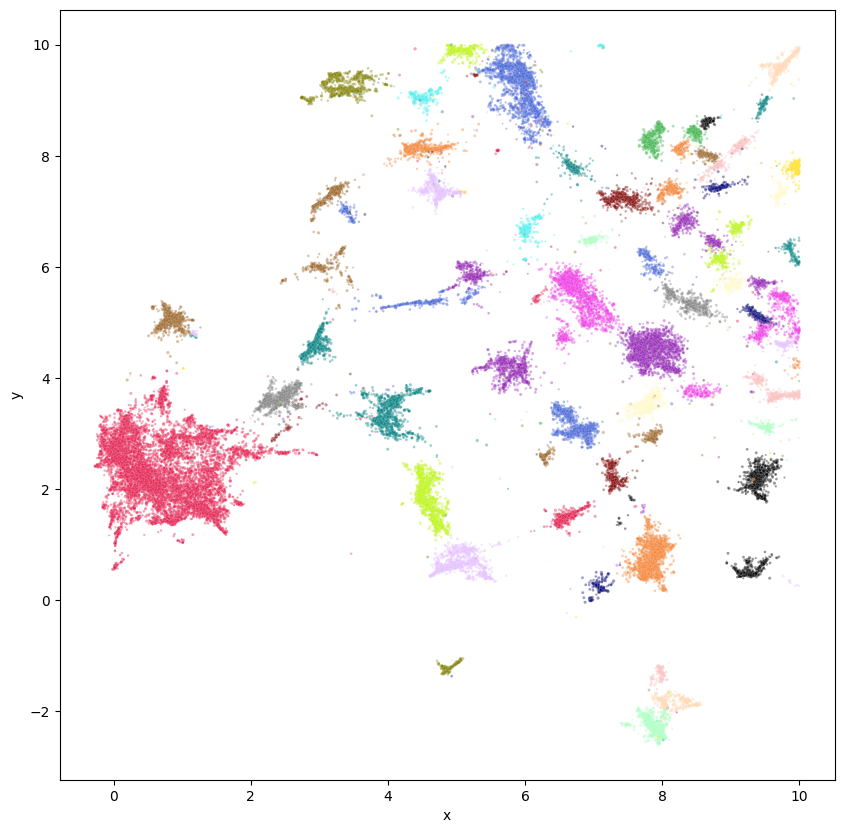

In [30]:
import seaborn as sns
from matplotlib import pyplot as plt
from adjustText import adjust_text
import matplotlib.patheffects as pe
import textwrap

fig = plt.figure(figsize=(10, 10))plt
sns.scatterplot(data=df, x='x', y='y', c=df['Topic'].map(color_key), alpha=0.4, sizes=(0.4, 10), size="Length")

# Annotate top 50 topics
texts, xs, ys = [], [], []
for row in mean_df.iterrows():
  topic = row[1]["Topic"]
  name = textwrap.fill(topic_model.custom_labels_[int(topic)], 20)

  if int(topic) <= 50:
    xs.append(row[1]["x"])
    ys.append(row[1]["y"])
    texts.append(plt.text(row[1]["x"], row[1]["y"], name, size=10, ha="center", color=color_key[str(int(topic))],
                          path_effects=[pe.withStroke(linewidth=0.5, foreground="black")]
                          ))

# Adjust annotations such that they do not overlap
adjust_text(texts, x=xs, y=ys, time_lim=1, force_text=(0.01, 0.02), force_static=(0.01, 0.02), force_pull=(0.5, 0.5))
plt.axis('off')
plt.legend('', frameon=False)
plt.show()

# Backup Saving

In [ ]:
# To save: model, reduced embeddings, representative docs
!pip install safetensors

In [ ]:
import pickle

with open('rep_docs.pickle', 'wb') as handle:
    pickle.dump(topic_model.representative_docs_, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('reduced_embeddings.pickle', 'wb') as handle:
    pickle.dump(reduced_embeddings, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('filename.pickle', 'rb') as handle:
#     b = pickle.load(handle)

In [ ]:
embedding_model = "BAAI/bge-small-en"
topic_model.save("final", serialization="safetensors", save_ctfidf=True, save_embedding_model=embedding_model)

In [ ]:
!zip -r /content/llama2.zip /content/final

  adding: content/final/ (stored 0%)
  adding: content/final/ctfidf_config.json (deflated 65%)
  adding: content/final/topics.json (deflated 84%)
  adding: content/final/topic_embeddings.safetensors (deflated 7%)
  adding: content/final/ctfidf.safetensors (deflated 47%)
  adding: content/final/config.json (deflated 38%)


In [ ]:
!jupyter nbconvert --to markdown Topic_Modeling_with_Llama2.ipynb

[NbConvertApp] Converting notebook Topic_Modeling_with_Llama2.ipynb to markdown
[NbConvertApp] Support files will be in Topic_Modeling_with_Llama2_files/
[NbConvertApp] Making directory Topic_Modeling_with_Llama2_files
[NbConvertApp] Writing 13754635 bytes to Topic_Modeling_with_Llama2.md
